# Testing the Integrated Simulation Platform
This notebook contains codes to test the various functionalities of the integrated simulation platform. You can call any of the modules from the package here. 

In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import required packages

In [98]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import time
import re
from numpy import random
import random as rand

from dreaminsg_integrated_model.network_sim_models.interdependencies import *
import dreaminsg_integrated_model.network_sim_models.water.water_network_model as water
import dreaminsg_integrated_model.network_sim_models.power.power_system_model as power
import dreaminsg_integrated_model.network_sim_models.transportation.network as transpo
from dreaminsg_integrated_model.data.disruptive_scenarios.disrupt_generator import *

import dreaminsg_integrated_model.results.figures.plots as plots

import matplotlib.pyplot as plt

## Load the three infrastructure models: Water, Power and Transportation

Three different models are used:
- Water distribution network using **wntr** package
- Power systems using **pandapower** package
- Transportation network using static traffic assignment package developed by Dr. Stephen Boyles (University of Texas at Austin)

In [117]:
MAIN_DIR = Path('..')
ABS_MAIN_DIR = os.path.abspath('..')

#load water_network model
water_folder = MAIN_DIR/'dreaminsg_integrated_model/data/networks/water'
wn = water.load_water_network(water_folder/'Example_water.inp')
total_base_water_demand = sum([wn.get_node(node).base_demand for node in wn.junction_name_list])
#print(total_base_water_demand)

#load power systems network
power_folder = MAIN_DIR/'dreaminsg_integrated_model/data/networks/power'
pn = power.load_power_network(power_folder/'Example_power.json')
power.run_power_simulation(pn)
total_base_power_demand = pn.res_load.p_mw.sum() + pn.res_motor.p_mw.sum()
#print(total_base_power_demand)

#load dynamic traffic assignment model
transp_folder = MAIN_DIR/'dreaminsg_integrated_model/data/networks/transportation/Example1'
tn = transpo.Network(
    "{}/example_net.tntp".format(transp_folder), 
    "{}/example_trips.tntp".format(transp_folder),
    "{}/example_node.tntp".format(transp_folder))
tn.userEquilibrium("FW", 400, 1e-4, tn.averageExcessCost)

Water network successfully loaded from ..\dreaminsg_integrated_model\data\networks\water\Example_water.inp. The analysis type is set to Pressure De[endent Demand Analysis.
Power system successfully loaded from ..\dreaminsg_integrated_model\data\networks\power\Example_power.json
Iteration 1: gap 0.000305: time 0.000997
Iteration 2: gap 0.000000: time 0.003989


## Create a Networkx graph of the integrated infrastructure network.

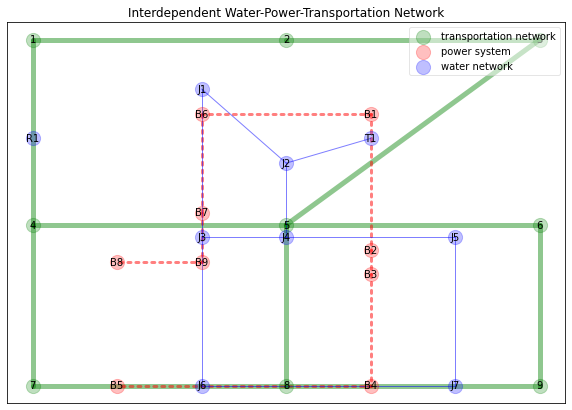

In [118]:
integrated_graph = plots.plot_integrated_network(pn, wn, tn)

## Build interdependencies

Three types of dependencies:
- Power - Water dependencies (eg.: water pump on electric motor, generator on reservoir)
- Power - Transportation dependencies (eg.: road access to power system components for M&R)
- Water - Transportation dependencies (eg.: road access to water network components for M&R)

The dependencies are referenced using two tables in the model.
- **wp_table** for water - power dependencies
- **access_table** for transportation dependencies

In [119]:
net1_deps = DependencyTable()

#water - power dependencies stored to wp_table
net1_deps.add_pump_motor_coupling(water_id='WP1', power_id='MP1', motor_mw=pn.motor.pn_mech_mw[pn.motor.name == 'MP1'].values[0], pm_efficiency=1.0)
net1_deps.add_gen_reserv_coupling(water_id='R1', power_id='G3', gen_mw=1, gr_efficiency=1.0)
net1_deps.wp_table.head()

,water_id,power_id,water_type,power_type
0,WP1,MP1,Pump,Motor
1,R1,G3,Reservoir,Generator


In [120]:
#transportation access dependencies saved to access_table
net1_deps.add_transpo_access(integrated_graph)
net1_deps.access_table

,origin_id,transp_id,origin_cat,origin_type,access_dist
0,B8,4,power,bus,125.00
1,B7,5,power,bus,103.08
2,B5,7,power,bus,100.00
3,B4,8,power,bus,100.00
4,B6,2,power,bus,180.28
5,B2,5,power,bus,111.80
6,B3,5,power,bus,141.42
7,B1,2,power,bus,180.28
8,B9,5,power,bus,125.00
9,J1,2,water,Juntion,141.42


## Simulation of interdependent effects using a test scenario
### (a) Scheduling infrastructure disruptions and optimal recovery actions.
Before we run the simulation, we need to specify the simulation parameters and recovery parameters.

In [121]:
#Setting recovery parameters
curr_loc_crew = 8
recovery_rate = 0.05

#Setting simulation parameters
sim_duration = 60*200
sim_step = 60

Now, we have to create a event table that has all the disruptions and recovery actions scheduled in it. For this first, we read the disruptive scenario file having information only about the disruptive events. The we add the disruptive events to the main **event_table**.

In [122]:
# creating test case dataframe
scenario_file = '../dreaminsg_integrated_model/data/disruptive_scenarios/test1/motor_failure.csv'
motor_failure = DisruptionAndRecovery(scenario_file, sim_duration, sim_step, curr_loc_crew)
motor_failure.disruptive_events

,time_stamp,components,fail_perc
0,300,MP1,100
1,600,L4,50
2,900,L3,30


In [123]:
motor_failure.event_table.head()

,time_stamp,MP1,L4,L3
0,0,100,100,100
1,60,100,100,100
2,120,100,100,100
3,180,100,100,100
4,240,100,100,100


Now, we identify the optimized recovery strategy (order of restoration/repair) and schedule the recovery actions in the **event_table**. The travel time for the repair crew from current location to the next location is computed using the transportation network model. 

In [124]:
#Simulating repair curves
repair_order = motor_failure.optimze_recovery_strategy() #Felix' model will be embedded in this method.
print("The optimsed repair stragegy is to shcedule repair of failed components in the following order: {}\n".format(repair_order))

for index, node in enumerate(repair_order):
    origin_node = node
    compon_infra = interdependencies.get_infra_type(origin_node)

    if compon_infra == "power":
        connected_bus = find_connected_power_node(origin_node, pn)
        nearest_node, near_dist = get_nearest_node(integrated_graph, connected_bus, "transpo_node")
        #print("The nearest node to {} is {} at a distance of {}m.".format(origin_node, nearest_node, near_dist))
    elif compon_infra == "water":
        connected_node = find_connected_water_node(origin_node, wn)
        nearest_node, near_dist = get_nearest_node(integrated_graph, connected_node, "transpo_node")

    travel_time = int(round(tn.calculateShortestTravelTime(curr_loc_crew, nearest_node), 0))
    print("The crew is currently (at t = {} minutes) at node {}. It will take {} minutes to reach nearest node {}, the nearest transportation node from {}.".format(
        motor_failure.next_crew_trip_start/motor_failure.sim_step, motor_failure.curr_loc_crew, travel_time, nearest_node, node))
    recovery_start = motor_failure.next_crew_trip_start + travel_time*60

    #Schedule the recovery action
    recovery_start = motor_failure.next_crew_trip_start + travel_time*60
    motor_failure.schedule_recovery(origin_node, recovery_start, recovery_rate)
print("All restoration actions are successfully scheduled.")

The optimsed repair stragegy is to shcedule repair of failed components in the following order: ['L4', 'L3', 'MP1']

The crew is currently (at t = 5.0 minutes) at node 8. It will take 13 minutes to reach nearest node 2, the nearest transportation node from L4.
The repair action at L4 successfuly completed at time 35.0 minutes

The crew is currently (at t = 35.0 minutes) at node L4. It will take 0 minutes to reach nearest node 8, the nearest transportation node from L3.
The repair action at L3 successfuly completed at time 45.0 minutes

The crew is currently (at t = 45.0 minutes) at node L3. It will take 8 minutes to reach nearest node 4, the nearest transportation node from MP1.
The repair action at MP1 successfuly completed at time 87.0 minutes

All restoration actions are successfully scheduled.


In [114]:
#list(motor_failure.event_table.MP1.values)

### (b) Simulating the interdependent effects
Now, the integrated network simulation is run with operational parameters of disrupted components fetched from the **event_table**.

In [125]:
power_consump_tracker = []
water_consump_tracker = []
time_tracker = []

#simulating the netwokwide impacts
for index, row in motor_failure.event_table.iterrows():
    #Update the operational level of directly affected components
    motor_failure.update_directly_affected_components(pn, wn, index)
    #print(pn['motor'].pn_mech_mw.item())

    #run power systems model
    power.run_power_simulation(pn)

    #Fix the time until which the wntr model should run in this iteration
    wn.options.time.duration = sim_step*(index)

    #set the pump power value based on motor power value
    net1_deps.update_dependencies(pn, wn)
    
    #run water distribution model and save current status
    wn_results = water.run_water_simulation(wn, sim_step)
    #pressure = wn_results.node['pressure']
    flowrate = wn_results.link['flowrate']
    #print(flowrate.values)

    #track results
    time_tracker.append(int(row['time_stamp']/sim_step))
    power_consump_tracker.append((pn.res_load.p_mw.sum() + pn.res_motor.p_mw.sum())/total_base_power_demand)
    water_consump_tracker.append(sum([wn.get_node(node).demand for node in wn.junction_name_list])/total_base_water_demand)
    
    if index % 10 == 0:
        print("Simulation for time {} minutes completed successfully".format(index))

Simulation for time 0 minutes completed successfully
Simulation for time 10 minutes completed successfully
Simulation for time 20 minutes completed successfully
Simulation for time 30 minutes completed successfully
Simulation for time 40 minutes completed successfully
Simulation for time 50 minutes completed successfully
Simulation for time 60 minutes completed successfully
Simulation for time 70 minutes completed successfully
Simulation for time 80 minutes completed successfully
Simulation for time 90 minutes completed successfully
Simulation for time 100 minutes completed successfully
Simulation for time 110 minutes completed successfully
Simulation for time 120 minutes completed successfully
Simulation for time 130 minutes completed successfully
Simulation for time 140 minutes completed successfully
Simulation for time 150 minutes completed successfully
Simulation for time 160 minutes completed successfully
Simulation for time 170 minutes completed successfully
Simulation for time 1

### Plot the direct and interdependent effects

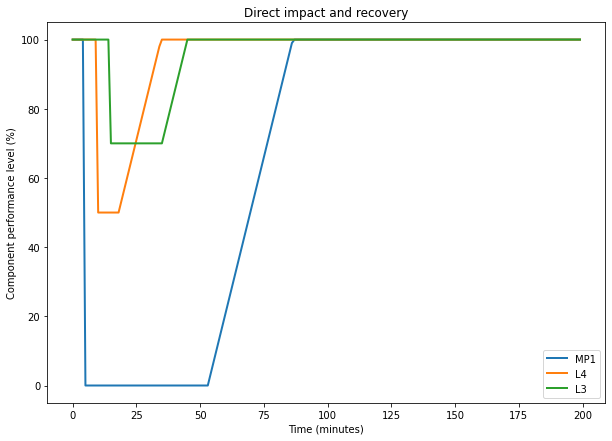

In [126]:
#Plotting repair curves
plots.plot_repair_curves(motor_failure)

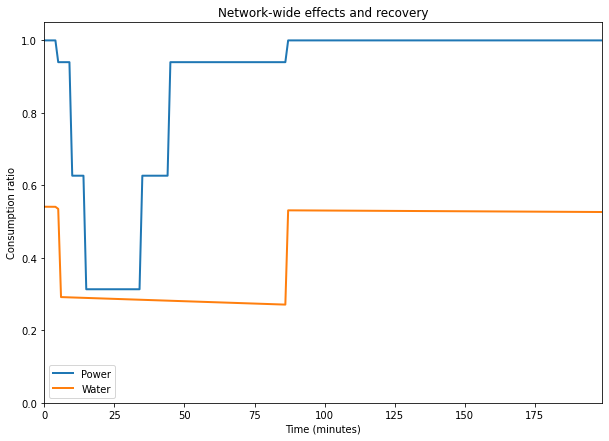

In [127]:
plots.plot_interdependent_effects(power_consump_tracker, water_consump_tracker, time_tracker)